In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d
import matplotlib.patches as mpatches

import matplotlib.colors as colors

In [2]:
from tphenotype import LaplaceEncoder, Predictor
from tphenotype.baselines import E2P, KME2P, KMDTW
from tphenotype.utils import get_auc_scores, get_cls_scores, select_by_steps, get_one_hot, data_split
from tphenotype.utils.dataset import cut_windowed_data

In [3]:
import sys
import os
import pickle

In [4]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


### load the synthetic data and check the label distribution 

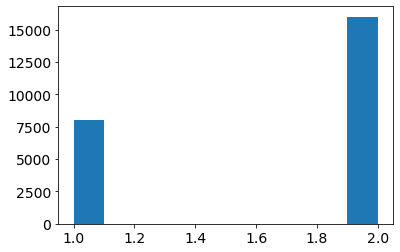

In [5]:
data = np.load('../data/synthetic/data-mixed.npz')
data_t,data_x,data_y,data_c,data_mask = data['t'], data['x'], data['y'], data['c'], data['mask']

_ = plt.hist(data_y.flatten())

N, T = data_y.shape
# we know that there are 2 labels. so nb_classes = 2
y_onehot = get_one_hot(data_y.reshape((N * T,)) - 1, 2).reshape((N, T, 2))

# window size is the "real" size in time, not for indices.
# e.g., a window_size of 2 selects all time points in a range of [t,t+2].
window_size = 2
t, x, y, m = cut_windowed_data(data_t, data_x, y_onehot, data_mask, window_size=window_size)
_, _, c, range_m = cut_windowed_data(data_t, data_x, data_c, data_mask, window_size=window_size, range_mask=True)
# c is the cluster label
c = c[:, :, 0]

t_orig = t.copy()
t_orig[range_m == 0] = 1e10 # these time points are not used; value can be set arbitrarily large.

t = t_orig - t_orig.min(axis=-1, keepdims=True) # we align all time-series at t=0
t[range_m == 0] = 0
t_orig[range_m == 0] = 0
t_scale = t.max() - t.min()
t = (t - t.min()) / t_scale

feat_list = ['x1', 'x2']
temporal_dims = [0, 1]

dataset_Synth = {
    't': t,
    't_orig': t_orig,
    'x': x,
    'y': y,
    'mask': m,
    'range_mask': range_m,
    'c': c,
}


In [6]:
data_t.shape, data_x.shape, data_y.shape, data_mask.shape

((1200, 20), (1200, 20, 2), (1200, 20), (1200, 20))

In [7]:
# t contains the time points of observations in x. For one sample, all time points are shared.
data_t[0]

array([0.07103095, 0.12254369, 0.15905209, 0.36898586, 0.47212741,
       0.5187458 , 0.64499972, 0.78307999, 0.81441989, 0.92914398,
       0.9807194 , 1.06573479, 1.18260203, 1.27111792, 1.36630843,
       1.52815832, 1.59560074, 1.72055699, 1.81489943, 2.        ])

In [8]:
# mask indicates all valid observation points until final label y is given. 
data_mask[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [9]:
# we convert the mask to indicate the final time point where predictions are made
m[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1.])

In [10]:
# the original mask is kept in range_m
range_m[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

### We visualize the phenotypes that are defined by periodicity in $x_2$

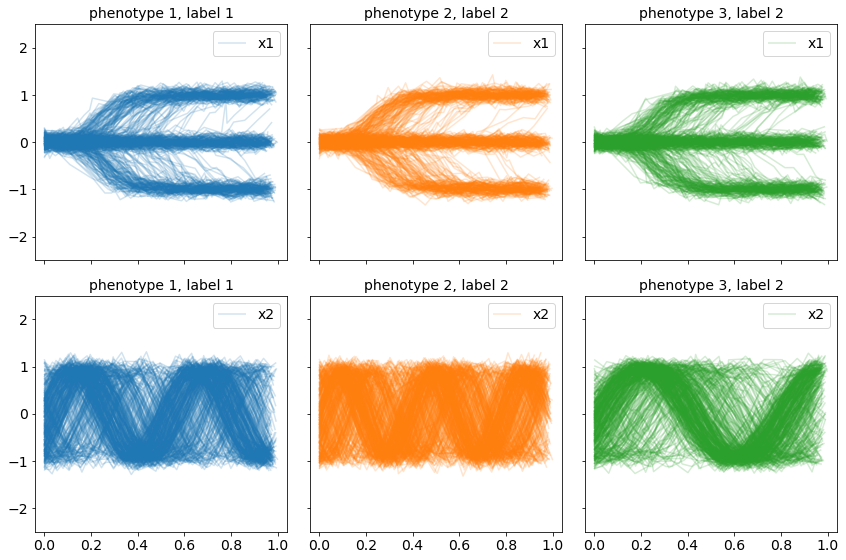

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(4*3,4*2),sharex=True,  sharey=True)
for x_dim in range(2):
    for p in range(3):
        ax = axs[x_dim, p]
        idx, = np.where(c[:,-1]==p+1)
        line_segments = LineCollection([np.column_stack([ti, xi]) for ti,xi in zip(t[idx], x[idx,:,x_dim])], label=f'x{x_dim+1}', color=plt.cm.tab10(p),alpha=0.2)
        ax.add_collection(line_segments)
        ax.set_title(f'phenotype {p+1}, label {1+np.argmax(y[idx[0],-1])}')
        ax.legend()
        ax.set_xlim([-0.04,1.04])
        ax.set_ylim([-2.5,2.5])  
fig.tight_layout()

### Prepare datasets

In [12]:
seed=0
dtype='float32'
N, T, x_dim = x.shape
_, _, y_dim = y.shape


train_set, test_set = data_split(dataset_Synth, test_size=0.2, random_state=seed, dtype=dtype)
train_set, valid_set = data_split(train_set, test_size=0.2, random_state=seed, dtype=dtype)

In [13]:
train_set['x'].shape,valid_set['x'].shape, test_set['x'].shape

((768, 20, 2), (192, 20, 2), (240, 20, 2))

### Set up model

In [14]:
encoder_config = {
    'num_poles': 4,    # number of poles
    'max_degree': 1,    # maximum degree of poles
    'hidden_size': 10,    # number of hidden units in neural networks
    'num_layers': 1,    # number of layers in MLP of the encoder (1 layer RNN + n layer MLP)
    'pole_separation': 2.0,    # minimum distance between distinct poles 
    'freq_scaler': 20,    # scale up the imaginary part to help learning
    'window_size': None,    # whether or not to include time delay terms
    'equivariant_embed': True,    # whether or not to sort the poles (useless during training)
}

cls_config = {
    'K': 3,
    'steps': [-1],
    'tol': 1e-6,
    'test_num': 50,
}

predictor_config = {
    'x_dim': x_dim,
    'y_dim': y_dim,
    'time_series_dims': temporal_dims, # indices of time-series dimensions
    'hidden_size': 10,
    'num_layer' : 3,
    'global_bias':False,
    'categorical':True,
    'encoder_config': encoder_config,
    'cls_config': cls_config,
}

loss_weights = {
    'ce': 1.0,
    'pole': 1.0,
    'real': 0.1,
    'cont': 0.01,
}

torch.random.manual_seed(seed)
model = Predictor(**predictor_config)

### Train the model

In [15]:
model = model.fit(train_set, loss_weights,valid_set=valid_set,epochs=50, tolerance=None)

stage 1 - fit the Laplace Encoder 1/2


  0%|          | 0/50 [00:00<?, ?it/s]

stage 1 - fit the Laplace Encoder 2/2


  0%|          | 0/50 [00:00<?, ?it/s]

stage 2 - fit the predictor


  0%|          | 0/50 [00:00<?, ?it/s]

stage 3 - clustering on similarity graph
construct similarity graph


  0%|          | 0/491 [00:00<?, ?it/s]

discover clusters from similarity graph
done


### Check the time-series reconstruction results

In [16]:
x = test_set['x']
t = test_set['t']
c = test_set['c']

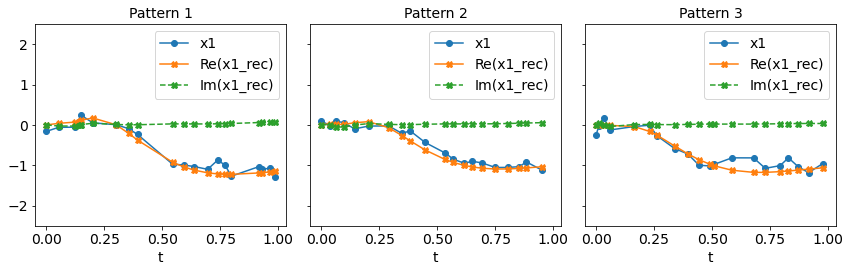

In [17]:
dim=0
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(4*3,4),sharex=True,  sharey=True)
for i,label in enumerate([0,1,2]):
    ax = axs[i]
    idx, = np.where(c[:,-1]==label+1)
    i=idx[-1]
    x1 = x[i,:,dim]
    t1 = t[i,:]
    pole,coef = model.encoders[dim].encode(x1,t1)
    x1_rec_r, x1_rec_i = model.encoders[dim].decode(pole,coef, t1)
    ax.plot(t1,x1,label=f'x{dim+1}',marker='o')
    ax.plot(t1,x1_rec_r[0,-1,:],label=f'Re(x{dim+1}_rec)',marker='X')
    ax.plot(t1,x1_rec_i[0,-1,:],label=f'Im(x{dim+1}_rec)',marker='X',linestyle='dashed')
    ax.set_ylim([-2.5,2.5])
    ax.set_xlabel('t')
    ax.legend()
    ax.set_title(f'Pattern {label+1}')
fig.tight_layout()


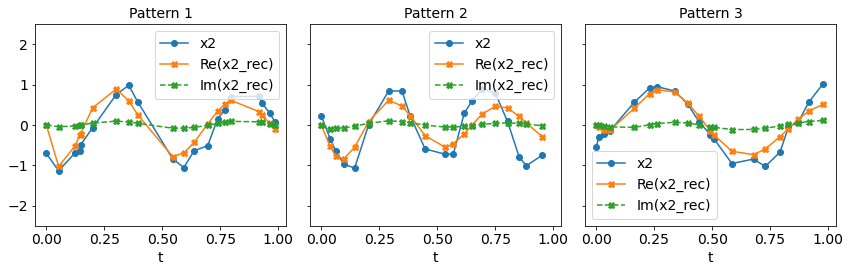

In [18]:
dim=1
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(4*3,4),sharex=True,  sharey=True)
for i,label in enumerate([0,1,2]):
    ax = axs[i]
    idx, = np.where(c[:,-1]==label+1)
    i=idx[-1]
    x1 = x[i,:,dim]
    t1 = t[i,:]
    pole,coef = model.encoders[dim].encode(x1,t1)
    x1_rec_r, x1_rec_i = model.encoders[dim].decode(pole,coef, t1)
    ax.plot(t1,x1,label=f'x{dim+1}',marker='o')
    ax.plot(t1,x1_rec_r[0,-1,:],label=f'Re(x{dim+1}_rec)',marker='X')
    ax.plot(t1,x1_rec_i[0,-1,:],label=f'Im(x{dim+1}_rec)',marker='X',linestyle='dashed')
    ax.set_ylim([-2.5,2.5])
    ax.set_xlabel('t')
    ax.legend()
    ax.set_title(f'Pattern {label+1}')
fig.tight_layout()


### Compare the (top-3) discovered clusters with ground-truth

In [19]:
x = test_set['x']
y_true = test_set['y']
mask = test_set['mask']
c = test_set['c'] # ground truth cluster label
t = test_set['t']
steps = [-1]
y_pred = model.predict_proba(x,t, mask, steps)
c_pred = model.cls.predict(x, t, mask, steps) # predicted cluster label
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_true,axis=-1)

#### Discovered by TPhenotype

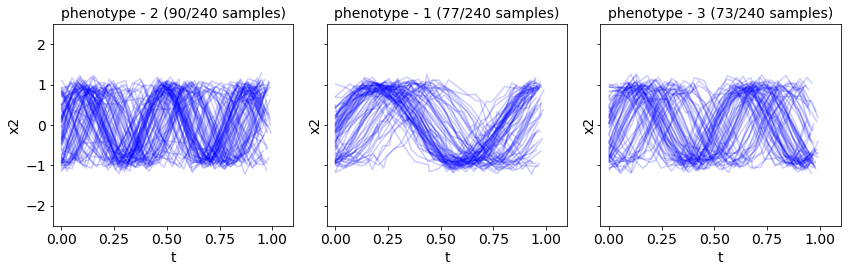

In [20]:
labels = model.cls.label_corpus
unique_labels, count = np.unique(c_pred,return_counts=True)
idx = np.argsort(count)[::-1]
# top 6 clusters in training samples
top_labels = unique_labels[idx][:3]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(4*3,4),sharex=True,  sharey=True)
for i,label in enumerate(top_labels):
    ax = axs[i]
    idx, = np.where((c_pred==label))
    
    line_segments = LineCollection([np.column_stack([ti, xi]) for ti,xi in zip(t[idx], x[idx,:,1])], color='blue',alpha=0.2)
    ax.add_collection(line_segments)
    ax.set_title(f'Cluster - {label+1}')
    ax.set_title(f'phenotype - {label+1} ({len(idx)}/{len(c_pred)} samples)')
    
    ax.set_xlim([-0.04,1.1])
    ax.set_ylim([-2.5,2.5])
    ax.set_xlabel('t')
    ax.set_ylabel('x2')
fig.tight_layout()


### Ground truth

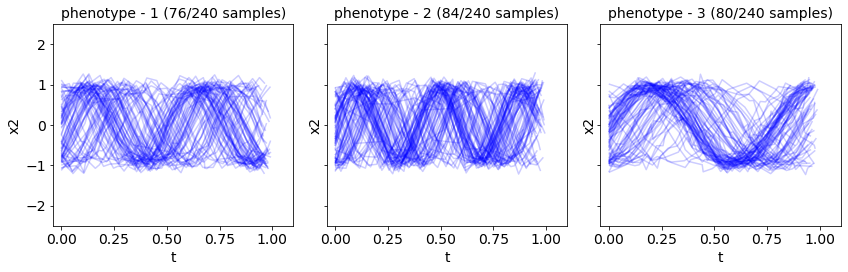

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(4*3,4),sharex=True,  sharey=True)
for i,label in enumerate(range(3)):
    ax = axs[i]
    idx, = np.where((c[:,-1]==label+1))
    
    line_segments = LineCollection([np.column_stack([ti, xi]) for ti,xi in zip(t[idx], x[idx,:,1])], color='blue',alpha=0.2)
    ax.add_collection(line_segments)
    ax.set_title(f'phenotype - {label+1} ({len(idx)}/{len(c)} samples)')
    ax.set_xlim([-0.04,1.1])
    ax.set_ylim([-2.5,2.5])
    ax.set_xlabel('t')
    ax.set_ylabel('x2')
fig.tight_layout()